Features: ['temp', 'humidity', 'hour_sin', 'hour_cos', 'minute_sin', 'minute_cos', 'dev_device_1', 'dev_device_2', 'dev_device_3', 'dev_device_4', 'dev_device_5']
Data shape: (405184, 11) 202592 attacks out of 405184
Train total: 324147 Labeled subset: 64829 Unlabeled subset: 259318
Starting GAN training on attack subset...
GAN Epoch 1/100  D_loss=-0.2216  G_loss=-0.0377
GAN Epoch 20/100  D_loss=-0.2024  G_loss=0.0814
GAN Epoch 40/100  D_loss=-0.1447  G_loss=0.9947
GAN Epoch 60/100  D_loss=-0.1279  G_loss=1.9485
GAN Epoch 80/100  D_loss=-0.1166  G_loss=0.7012
GAN Epoch 100/100  D_loss=-0.1095  G_loss=-3.6511
GAN training finished.
Starting classifier training with ATSO loop...
Epoch 1/60  Acc=0.9419 Prec=0.9478 Rec=0.9353 F1=0.9415 AUC=0.9894
Confusion matrix:
 [[38430  2089]
 [ 2622 37896]]
Epoch 5/60  Acc=0.9497 Prec=0.9449 Rec=0.9551 F1=0.9500 AUC=0.9926
Confusion matrix:
 [[38264  2255]
 [ 1821 38697]]
Epoch 10/60  Acc=0.9529 Prec=0.9466 Rec=0.9599 F1=0.9532 AUC=0.9941
Confusion ma

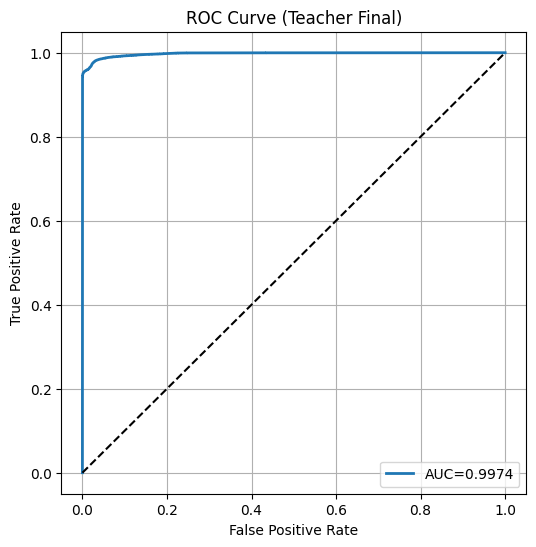

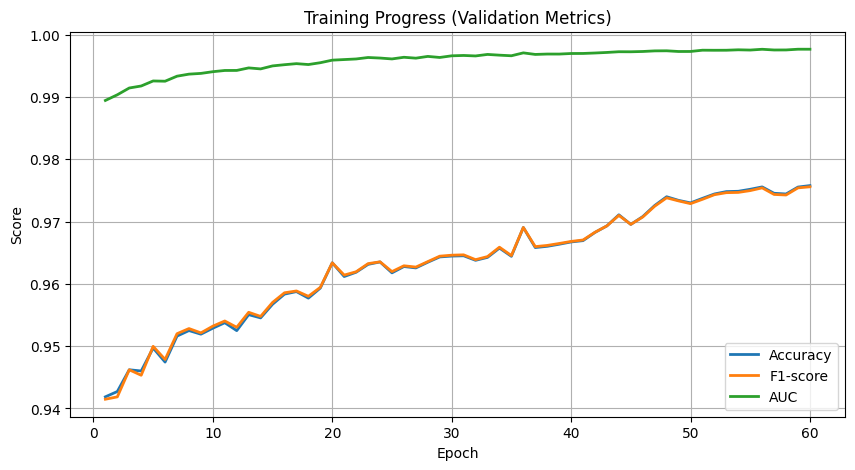

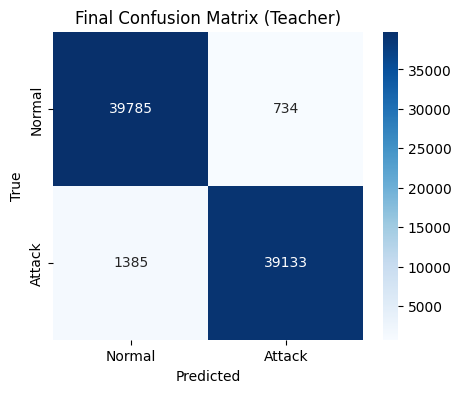

Saved predictions to: ./models_ids/test_predictions.csv


In [ ]:
# ids_gan_atso.py
# Full pipeline: load IDS-ready CSV, train GAN for augmentation, then classifier with ATSO-like teacher-student + adaptive LR.
# Requires: torch, sklearn, pandas, numpy, tqdm, matplotlib (optional)
# Usage: python ids_gan_atso.py

import os
import math
import random
import numpy as np
import pandas as pd
from datetime import datetime

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.optim import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve

# --------------------------
# Config / Hyperparameters
# --------------------------
DATA_PATH = "/content/iot_telemetry_ids_ready.csv"   # your generated file
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# GAN params
GAN_EPOCHS = 100
G_BATCH_SIZE = 256
LATENT_DIM = 16
GAN_LR = 2e-4
CRITIC_ITERS = 5  # WGAN-GP style
GRAD_PENALTY_WEIGHT = 10.0

# Classifier / ATSO params
CLASS_BATCH_SIZE = 256
CLASS_EPOCHS = 60
CLASS_LR = 1e-3
WEIGHT_DECAY = 1e-5
EMA_DECAY = 0.999  # teacher smoothing
UNLABELED_FRACTION = 0.8  # fraction of train considered "unlabeled" for ATSO pseudo-labeling
LABELED_FRACTION = 0.2    # fraction labeled (simulated)
PSEUDO_LABEL_CONFIDENCE = 0.9  # threshold for using pseudo labels
AUGMENT_SYNTHETIC = True     # whether to augment classifier trainset with GAN-samples

MODEL_DIR = "./models_ids"
os.makedirs(MODEL_DIR, exist_ok=True)
SEED = 42

# --------------------------
# Utilities / Seeds
# --------------------------
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(SEED)

# --------------------------
# Load & preprocess dataset
# --------------------------
df = pd.read_csv(DATA_PATH)

# Expected columns: temp, humidity, device_id, timestamp, label, attack_type
# Keep only required columns; if names mismatch, adjust.
required_cols = ['temp', 'humidity', 'device_id', 'timestamp', 'label', 'attack_type']
for c in required_cols:
    if c not in df.columns:
        raise ValueError(f"Expected column '{c}' in {DATA_PATH} but not found.")

# Feature engineering: numeric features + device one-hot + cyclical time features (hour, minute)
def preprocess_df(df):
    df2 = df.copy()
    # Ensure timestamp is datetime
    df2['timestamp'] = pd.to_datetime(df2['timestamp'])
    df2['hour'] = df2['timestamp'].dt.hour
    df2['minute'] = df2['timestamp'].dt.minute
    # cyclical transform for hour/minute
    df2['hour_sin'] = np.sin(2 * np.pi * df2['hour'] / 24.0)
    df2['hour_cos'] = np.cos(2 * np.pi * df2['hour'] / 24.0)
    df2['minute_sin'] = np.sin(2 * np.pi * df2['minute'] / 60.0)
    df2['minute_cos'] = np.cos(2 * np.pi * df2['minute'] / 60.0)

    # Device one-hot
    device_ohe = pd.get_dummies(df2['device_id'], prefix='dev')
    df2 = pd.concat([df2, device_ohe], axis=1)

    # numeric features selection
    features = ['temp', 'humidity', 'hour_sin', 'hour_cos', 'minute_sin', 'minute_cos'] + list(device_ohe.columns)
    X = df2[features].astype(float).values
    y = df2['label'].astype(int).values
    return X, y, features

X, y, feature_names = preprocess_df(df)
print(f"Features: {feature_names}")
print("Data shape:", X.shape, y.sum(), "attacks out of", len(y))

# Standardize numeric features (only temp/humidity/hour/minute cyclical)
scaler = StandardScaler()
X[:, :6] = scaler.fit_transform(X[:, :6])  # first 6 are numeric/cyclical

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=SEED)

# For ATSO simulation: we will treat a fraction of training data as labeled
idx = np.arange(len(X_train))
train_l_idx, train_u_idx = train_test_split(idx, test_size=UNLABELED_FRACTION, stratify=y_train, random_state=SEED)
# train_l_idx: labeled subset, train_u_idx: unlabeled subset (we still have labels but will simulate unlabeled)

print("Train total:", len(X_train), "Labeled subset:", len(train_l_idx), "Unlabeled subset:", len(train_u_idx))

# --------------------------
# PyTorch Dataset wrappers
# --------------------------
class TabularDataset(Dataset):
    def __init__(self, X, y=None):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = None if y is None else torch.tensor(y, dtype=torch.long)

    def __len__(self): return len(self.X)
    def __getitem__(self, i):
        if self.y is None:
            return self.X[i]
        return self.X[i], self.y[i]

train_l_ds = TabularDataset(X_train[train_l_idx], y_train[train_l_idx])
train_u_ds = TabularDataset(X_train[train_u_idx])  # unlabeled (we keep labels separately for eval)
train_full_ds = TabularDataset(X_train, y_train)
test_ds = TabularDataset(X_test, y_test)

train_l_dl = DataLoader(train_l_ds, batch_size=CLASS_BATCH_SIZE, shuffle=True, drop_last=True)
train_u_dl = DataLoader(train_u_ds, batch_size=CLASS_BATCH_SIZE, shuffle=True, drop_last=True)
train_full_dl = DataLoader(train_full_ds, batch_size=CLASS_BATCH_SIZE, shuffle=True, drop_last=False)
test_dl = DataLoader(test_ds, batch_size=CLASS_BATCH_SIZE, shuffle=False)

# Also create index-based access for unlabeled pseudo-label updates
X_train_u = X_train[train_u_idx]
y_train_u = y_train[train_u_idx]

# --------------------------
# GAN: generator and critic (WGAN-GP style) for tabular data
# --------------------------
DIMS = X.shape[1]

def weights_init(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)

class Generator(nn.Module):
    def __init__(self, latent_dim, out_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, out_dim)
        )
    def forward(self, z):
        return self.net(z)

class Critic(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 1)
        )
    def forward(self, x):
        return self.net(x).view(-1)

# Instantiate GAN
G = Generator(LATENT_DIM, DIMS).to(DEVICE)
D = Critic(DIMS).to(DEVICE)
G.apply(weights_init)
D.apply(weights_init)

opt_G = Adam(G.parameters(), lr=GAN_LR, betas=(0.5, 0.9))
opt_D = Adam(D.parameters(), lr=GAN_LR, betas=(0.5, 0.9))

# We'll train GAN on the attack samples only (so it can generate attack samples to augment)
X_attacks = X_train[y_train == 1]
attack_ds = TabularDataset(X_attacks)
attack_dl = DataLoader(attack_ds, batch_size=G_BATCH_SIZE, shuffle=True, drop_last=True)

def gradient_penalty(critic, real_data, fake_data):
    alpha = torch.rand(real_data.size(0), 1).to(DEVICE)
    alpha = alpha.expand_as(real_data)
    interpolates = alpha * real_data + (1 - alpha) * fake_data
    interpolates.requires_grad_(True)
    d_interpolates = critic(interpolates)
    grads = torch.autograd.grad(outputs=d_interpolates, inputs=interpolates,
                                grad_outputs=torch.ones_like(d_interpolates).to(DEVICE),
                                create_graph=True, retain_graph=True, only_inputs=True)[0]
    grads = grads.view(grads.size(0), -1)
    grad_norm = torch.sqrt(torch.sum(grads ** 2, dim=1) + 1e-12)
    gp = ((grad_norm - 1.0) ** 2).mean()
    return gp

print("Starting GAN training on attack subset...")
for epoch in range(GAN_EPOCHS):
    d_losses = []
    g_losses = []
    for real in attack_dl:
        real = real.to(DEVICE)
        # Train critic
        for _ in range(CRITIC_ITERS):
            z = torch.randn(real.size(0), LATENT_DIM).to(DEVICE)
            fake = G(z).detach()
            d_real = D(real)
            d_fake = D(fake)
            gp = gradient_penalty(D, real, fake)
            d_loss = d_fake.mean() - d_real.mean() + GRAD_PENALTY_WEIGHT * gp
            opt_D.zero_grad()
            d_loss.backward()
            opt_D.step()

        # Train generator
        z = torch.randn(real.size(0), LATENT_DIM).to(DEVICE)
        fake = G(z)
        g_loss = -D(fake).mean()
        opt_G.zero_grad()
        g_loss.backward()
        opt_G.step()

        d_losses.append(d_loss.item())
        g_losses.append(g_loss.item())

    if (epoch + 1) % 20 == 0 or epoch == 0:
        print(f"GAN Epoch {epoch+1}/{GAN_EPOCHS}  D_loss={np.mean(d_losses):.4f}  G_loss={np.mean(g_losses):.4f}")

print("GAN training finished.")

# Function to sample synthetic attack examples
def sample_gan_attacks(n):
    G.eval()
    with torch.no_grad():
        z = torch.randn(n, LATENT_DIM).to(DEVICE)
        synth = G(z).cpu().numpy()
    return synth

# --------------------------
# Classifier: student + teacher (EMA)
# --------------------------
class Classifier(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 2)
        )
    def forward(self, x):
        return self.net(x)

student = Classifier(DIMS).to(DEVICE)
teacher = Classifier(DIMS).to(DEVICE)
teacher.load_state_dict(student.state_dict())  # initialize identical
for p in teacher.parameters():
    p.requires_grad = False

optimizer = Adam(student.parameters(), lr=CLASS_LR, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5)

criterion = nn.CrossEntropyLoss()

def update_ema(teacher, student, alpha):
    for t_param, s_param in zip(teacher.parameters(), student.parameters()):
        t_param.data.mul_(alpha).add_(s_param.data * (1.0 - alpha))

# ATSO-like routine: partition unlabeled train_u into A and B, alternate.
# We will use pseudo-labeling from teacher on one partition and fine-tune student on it,
# while using the other partition for label updates in the next cycle.

# Partition unlabeled set into two halves A and B
perm = np.random.permutation(len(X_train_u))
mid = len(perm) // 2
A_idx = perm[:mid]
B_idx = perm[mid:]

X_A = X_train_u[A_idx]
X_B = X_train_u[B_idx]
y_A_true = y_train_u[A_idx]  # we keep true labels for eval only
y_B_true = y_train_u[B_idx]

# Start ATSO-classifier training
best_val_auc = 0.0
history = []

# Optionally augment labeled set with GAN-sampled attacks to balance / enlarge data
def get_augmented_labeled_set(num_synth_per_class=1000):
    # Combine labeled real data with synthetic attack samples and synthetic normal (if desired)
    X_l = X_train[train_l_idx].copy()
    y_l = y_train[train_l_idx].copy()

    if AUGMENT_SYNTHETIC:
        # produce synthetic attacks
        n_synth = num_synth_per_class
        synth_att = sample_gan_attacks(n_synth)
        # invert scaling for first 6 features? no need; GAN produced standardized features (we trained on standardized)
        y_synth = np.ones(n_synth, dtype=int)
        X_l = np.vstack([X_l, synth_att])
        y_l = np.hstack([y_l, y_synth])

    return X_l, y_l

print("Starting classifier training with ATSO loop...")

for epoch in range(CLASS_EPOCHS):
    student.train()
    teacher.train()  # teacher is not updated by optimizer, but used to generate pseudo-labels

    # --- Phase 1: generate pseudo-labels on partition A using teacher, fine-tune student on A (student learns from pseudo labels)
    # teacher produces softmax probs; we accept high-confidence pseudo-labels
    with torch.no_grad():
        teacher.eval()
        X_A_t = torch.tensor(X_A, dtype=torch.float32).to(DEVICE)
        logits_A = teacher(X_A_t)
        probs_A = F.softmax(logits_A, dim=1).cpu().numpy()
        pseudo_labels_A = np.argmax(probs_A, axis=1)
        pseudo_conf_A = np.max(probs_A, axis=1)

    # mask high-confidence pseudo labels
    high_conf_mask_A = pseudo_conf_A >= PSEUDO_LABEL_CONFIDENCE
    use_idx_A = np.where(high_conf_mask_A)[0]

    # prepare training data for this phase
    if len(use_idx_A) > 0:
        X_phase_A = X_A[use_idx_A]
        y_phase_A = pseudo_labels_A[use_idx_A]
        ds_phase_A = TabularDataset(X_phase_A, y_phase_A)
        dl_phase_A = DataLoader(ds_phase_A, batch_size=CLASS_BATCH_SIZE, shuffle=True)
        # train student
        for xb, yb in dl_phase_A:
            xb = xb.to(DEVICE); yb = yb.to(DEVICE)
            optimizer.zero_grad()
            out = student(xb)
            loss = criterion(out, yb)
            loss.backward()
            optimizer.step()
            # EMA update teacher
            update_ema(teacher, student, EMA_DECAY)

    # --- Phase 2: generate pseudo-labels on partition B using student (or teacher), fine-tune student on real labeled set + synthetic
    with torch.no_grad():
        student.eval()
        X_B_t = torch.tensor(X_B, dtype=torch.float32).to(DEVICE)
        logits_B = student(X_B_t)
        probs_B = F.softmax(logits_B, dim=1).cpu().numpy()
        pseudo_labels_B = np.argmax(probs_B, axis=1)
        pseudo_conf_B = np.max(probs_B, axis=1)
    high_conf_mask_B = pseudo_conf_B >= PSEUDO_LABEL_CONFIDENCE
    use_idx_B = np.where(high_conf_mask_B)[0]

    # Build labeled training set for second phase: original labeled set + high-conf pseudo-B + (optionally) GAN synth
    X_l_set, y_l_set = get_augmented_labeled_set(num_synth_per_class=512)
    if len(use_idx_B) > 0:
        X_l_set = np.vstack([X_l_set, X_B[use_idx_B]])
        y_l_set = np.hstack([y_l_set, pseudo_labels_B[use_idx_B]])

    # Train student for one epoch on X_l_set
    ds_l_mix = TabularDataset(X_l_set, y_l_set)
    dl_l_mix = DataLoader(ds_l_mix, batch_size=CLASS_BATCH_SIZE, shuffle=True)
    for xb, yb in dl_l_mix:
        xb = xb.to(DEVICE); yb = yb.to(DEVICE)
        optimizer.zero_grad()
        out = student(xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()
        update_ema(teacher, student, EMA_DECAY)

    # Optionally swap partitions for next epoch (asynchronous alternation)
    X_A, X_B = X_B, X_A
    y_A_true, y_B_true = y_B_true, y_A_true

    # Validation on holdout test set
    student.eval()
    preds = []
    probs = []
    ys = []
    with torch.no_grad():
        for xb, yb in test_dl:
            xb = xb.to(DEVICE)
            out = student(xb)
            p = F.softmax(out, dim=1)[:,1].cpu().numpy()
            pred = np.argmax(out.cpu().numpy(), axis=1)
            preds.append(pred)
            probs.append(p)
            ys.append(yb.numpy())
    preds = np.concatenate(preds)
    probs = np.concatenate(probs)
    ys = np.concatenate(ys)

    acc = accuracy_score(ys, preds)
    prec = precision_score(ys, preds, zero_division=0)
    rec = recall_score(ys, preds, zero_division=0)
    f1 = f1_score(ys, preds, zero_division=0)
    try:
        auc = roc_auc_score(ys, probs)
    except:
        auc = 0.0
    cm = confusion_matrix(ys, preds)

    scheduler.step(auc)  # adaptive LR based on validation AUC

    history.append({'epoch': epoch+1, 'acc': acc, 'prec': prec, 'rec': rec, 'f1': f1, 'auc': auc})

    # Save best
    if auc > best_val_auc:
        best_val_auc = auc
        torch.save(student.state_dict(), os.path.join(MODEL_DIR, "best_student.pth"))
        torch.save(teacher.state_dict(), os.path.join(MODEL_DIR, "best_teacher.pth"))

    if (epoch+1) % 5 == 0 or epoch == 0:
        print(f"Epoch {epoch+1}/{CLASS_EPOCHS}  Acc={acc:.4f} Prec={prec:.4f} Rec={rec:.4f} F1={f1:.4f} AUC={auc:.4f}")
        print("Confusion matrix:\n", cm)

print("Training finished. Best val AUC:", best_val_auc)

# Final evaluation with teacher (EMA) model (often more stable)
print("Evaluating saved best model...")
teacher.load_state_dict(torch.load(os.path.join(MODEL_DIR, "best_teacher.pth")))
teacher.eval()

preds = []
probs = []
ys = []
with torch.no_grad():
    for xb, yb in test_dl:
        xb = xb.to(DEVICE)
        out = teacher(xb)
        p = F.softmax(out, dim=1)[:,1].cpu().numpy()
        pred = np.argmax(out.cpu().numpy(), axis=1)
        preds.append(pred)
        probs.append(p)
        ys.append(yb.numpy())
preds = np.concatenate(preds)
probs = np.concatenate(probs)
ys = np.concatenate(ys)

acc = accuracy_score(ys, preds)
prec = precision_score(ys, preds, zero_division=0)
rec = recall_score(ys, preds, zero_division=0)
f1 = f1_score(ys, preds, zero_division=0)
auc = roc_auc_score(ys, probs)
cm = confusion_matrix(ys, preds)

print("Final metrics (teacher):")
print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1: {f1:.4f}")
print(f"AUC: {auc:.4f}")
print("Confusion matrix:\n", cm)

# Save final predictions to CSV for inspection
out_df = pd.DataFrame({
    'y_true': ys,
    'y_pred': preds,
    'y_prob': probs
})
# --------------------------
# Extra: Plots (ROC, Metrics, Confusion Matrix)
# --------------------------

# 1. ROC Curve (Teacher final model)
fpr, tpr, _ = roc_curve(ys, probs)
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"AUC={auc:.4f}", linewidth=2)
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Teacher Final)")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# 2. Training metrics over epochs (from history)
epochs = [h['epoch'] for h in history]
accs = [h['acc'] for h in history]
f1s = [h['f1'] for h in history]
aucs = [h['auc'] for h in history]

plt.figure(figsize=(10,5))
plt.plot(epochs, accs, label="Accuracy", linewidth=2)
plt.plot(epochs, f1s, label="F1-score", linewidth=2)
plt.plot(epochs, aucs, label="AUC", linewidth=2)
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.title("Training Progress (Validation Metrics)")
plt.legend()
plt.grid(True)
plt.show()

# 3. Confusion Matrix (Final teacher model)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Normal","Attack"],
            yticklabels=["Normal","Attack"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Final Confusion Matrix (Teacher)")
plt.show()

out_df.to_csv(os.path.join(MODEL_DIR, "test_predictions.csv"), index=False)

print("Saved predictions to:", os.path.join(MODEL_DIR, "test_predictions.csv"))
